In [1]:
# Here is where data is going to be put as we work on it for our individual projects.
# Make sure to write your individual data description on a personal page!

# Load from first tutorial first 2-3 lines, to get library dplyr to run this code!
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(dplyr)
players_data <- read_csv("dsci100data/players.csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
print(players_data)

# A tibble: 196 × 7
   experience subscribe hashedEmail              played_hours name  gender   Age
   <chr>      <lgl>     <chr>                           <dbl> <chr> <chr>  <dbl>
 1 Pro        TRUE      f6daba428a5e19a3d475748…         30.3 Morg… Male       9
 2 Veteran    TRUE      f3c813577c458ba0dfef809…          3.8 Chri… Male      17
 3 Veteran    FALSE     b674dd7ee0d24096d1c0196…          0   Blake Male      17
 4 Amateur    TRUE      23fe711e0e3b77f1da7aa22…          0.7 Flora Female    21
 5 Regular    TRUE      7dc01f10bf20671ecfccdac…          0.1 Kylie Male      21
 6 Amateur    TRUE      f58aad5996a435f16b0284a…          0   Adri… Female    17
 7 Regular    TRUE      8e594b8953193b26f498db9…          0   Luna  Female    19
 8 Amateur    FALSE     1d2371d8a35c8831034b25b…          0   Emer… Male      21
 9 Amateur    TRUE      8b71f4d66a38389b7528bb3…          0.1 Nata… Male      17
10 Veteran    TRUE      bbe2d83de678f519c4b3daa…          0   Nyla  Female    22
# ℹ 186 

Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_col()`).”


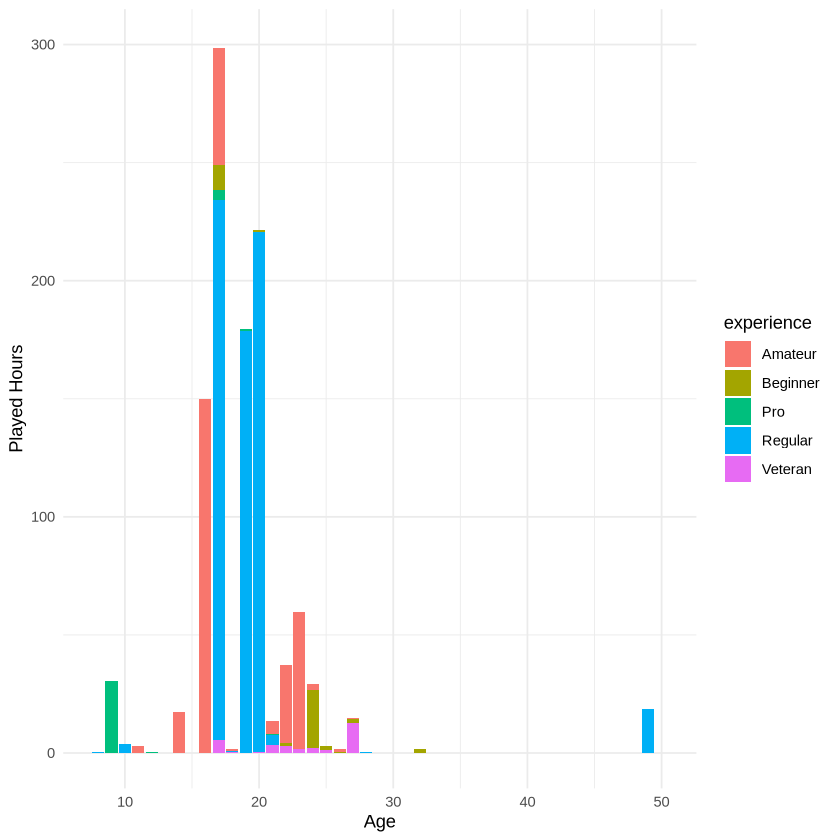

In [3]:

#Specific Question: “Can age predict the amount of playing time by individuals in [dataset]?”
#-Use players.csv
#-best fit line?
#-Histogram plot using age as x and playtime as y. 

players_clean <- players_data |>
    filter(!is.na(Age)) |>
    mutate(Age = as.numeric(Age), na.rm = TRUE)

players_plot <- ggplot(players_clean, aes(x = Age, y = played_hours, fill = experience)) + 
    geom_col() + # Check if we can use this command, geom_col()
    ylim(c(0,300)) + 
    labs(x = "Age", y = "Played Hours") +
    theme_minimal()
players_plot

# We want to also use a graph to help Predict these numerical variables, both Age and played hours. 
# But how can we find the correlation is here and not somewhere else?

In [4]:
# We can see that most values fall within age 17, and are at a Regular level. We'll show this in a bar graph
# But for now we can keep it in a scatter plot for KNN prediction

# We need to find whether age corresponds to play time. 

set.seed(9999)

data_split <- initial_split(players_clean, prop = 0.75, strata = played_hours)
# Since very few people played a lot of hours, we went with strata = played_hours at this time. It could also be Age.
train_data <- training(data_split)
test_data <- testing(data_split)
glimpse(train_data)

Rows: 145
Columns: 8
$ experience   <chr> "Veteran", "Regular", "Amateur", "Regular", "Amateur", "V…
$ subscribe    <lgl> FALSE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, FALSE, T…
$ hashedEmail  <chr> "b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118e…
$ played_hours <dbl> 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.…
$ name         <chr> "Blake", "Kylie", "Adrian", "Luna", "Natalie", "Nyla", "D…
$ gender       <chr> "Male", "Male", "Female", "Female", "Male", "Female", "Ma…
$ Age          <dbl> 17, 21, 17, 19, 17, 22, 17, 17, 22, 17, 17, 23, 18, 21, 1…
$ na.rm        <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRU…


In [5]:
players_recipe <- recipe(played_hours ~ Age, data = train_data) |> # This is according to the question
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec)

players_vfold <- vfold_cv(train_data, v = 5, strata = played_hours)

gridvals <- tibble(neighbors = seq(from = 1, to = min(50, nrow(train_data) - 1), by = 2)) # Since there is an error in this code, we need to 
# Find a way to remove Na from the played_hours I think, since that's where we're trying to sequence from.
# OLD CODE 3/04/25: gridvals <- tibble(neighbors = seq(from = 1, to = 114, by = 2))

gridvals <- tibble(neighbors = seq(from = 1, to = min(50, nrow(train_data) - 1), by = 2))


players_results <- players_workflow |>
 tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

players_results # This looks like the textbook now, so it seems alright, but double check with Professor

# Now we need to find the Minimum RSME:

players_min <- players_results |>
    filter(mean == min(mean))

players_min # This should show what the minimum RMSE is
# K = 52 is the best value to use. 
# Best K is identified as K = 139, but thats very high
# So we need to cross validate what we have so far first, then train, evaluate, and pick K from the lowest RSME
# 2, Train model on whole training dataset (not split into folds)
# 3, Evaluate how good the predictions are using the test data




neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,22.07566,5,10.217109,Preprocessor1_Model01
3,rmse,standard,25.54106,5,10.199621,Preprocessor1_Model02
5,rmse,standard,25.11966,5,9.731553,Preprocessor1_Model03
7,rmse,standard,24.50084,5,9.527383,Preprocessor1_Model04
9,rmse,standard,23.28763,5,9.859815,Preprocessor1_Model05
11,rmse,standard,22.94356,5,9.934654,Preprocessor1_Model06
13,rmse,standard,22.45444,5,10.089481,Preprocessor1_Model07
15,rmse,standard,22.28261,5,10.226860,Preprocessor1_Model08
17,rmse,standard,22.18770,5,10.229651,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,rmse,standard,21.2836,5,10.41503,Preprocessor1_Model16


In [6]:
# Now we can train the model on the whole data set, now that we have K = 52.
# This is 2,Train model on whole training dataset (not split into folds)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 52) |>
  set_engine("kknn") |>
  set_mode("regression")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
 add_model(players_spec) |>
  fit(data = train_data)

players_summary <- players_fit |>
  predict(test_data) |>
  bind_cols(test_data) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

players_summary
# the .estimate was 27.217. Is this a good estimate? We have to determine that ourselves, but it can be a significant difference.


#knn_fit <- workflow() |>
 # add_recipe(players_recipe) |>
  #add_model(knn_spec) |>
 # fit(data = train_data)

#knn_fit

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,27.21734


In [17]:
#Now we can see how it looks.
# This is 3,  Evaluate how good the predictions are using the test data
# We need to make this like the worksheet, so right now, I'm trying to set up players_min like maraton_min, 
# and so on. Follow the steps there. I dont think players_summary works because it doesnt have a neighbor column, so 
# Investigate
playtime_prediction_grid <- tibble(
    Age = seq(
        from = min(test_data$Age), 
        to = max(test_data$Age), 
        by = 1))
print(playtime_prediction_grid) 
# Make sure it says Age!

players_min <- players_summary |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()
players_min


# debug by making the code into seperate boxes and see about errors
# Not due for a while, so we can work ont his later. Looks fine so far
# If "Age not found", print out the data frame putting in

# k_min <- players_min |>
#     select(neighbors) |>
#       pull()
# k_min
    # This is where we left off. Investigate the code starting from Question 8.0 and using "marathon_results". Make
# this for players. 

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
          set_engine("kknn") |>
          set_mode("regression")

players_best_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_best_spec) |>
    fit(data = train_data)

players_preds <- players_fit |>
  predict(playtime_prediction_grid) |>
  bind_cols(playtime_prediction_grid)

plot_final <- ggplot(test_data, aes(x = played_hours, y = .pred)) + 
  geom_point(alpha = 0.4) +
  geom_line(data = players_preds,
            mapping = aes(x = Age, y = played_hours), # Why is it that Age isnt there? Fine to use players_preds
            color = "steelblue",
            linewidth = 1) +
  xlab("Age") +
  ylab("Hours Played (Hours)") +
  theme(text = element_text(size = 12))

plot_final

print(test_data)

# Proposal doesnt need any modelling, so we dont need to do lienar regression for proposal. This is helpful for report, and when with group. 

# A tibble: 36 × 1
     Age
   <dbl>
 1    11
 2    12
 3    13
 4    14
 5    15
 6    16
 7    17
 8    18
 9    19
10    20
# ℹ 26 more rows


[1] 27.21734

ERROR: Error: object 'k_min' not found
